# Quiz Time: Implement your own Deep Kernel Learning

reference reading: https://arxiv.org/pdf/1511.02222.pdf

### What is the biggest difference between kernel methods and neural networks? 

- Neural networks (NN) uses finitely many highly *adaptive* basis functions

- while kernel methods (KM) essentially uses infinitely many *fixed* basis functions.

In fact, one reason why NN works particularly well in practice is because is can automatically discover *meaningful representations* in high-dimensional data. 

On the other hand, kernel methods or Gaussian processes contains less design choice and are more straight forward to work with in practice.

### What's really the difference?

In NN, the key is about learning a representation of your data. For example,
- Convolutional NN for capturing spatial characteristics within your image, 
- LSTM structure for recurrent structural data.

While in kernel methods, we care more about how to utilise these high (infinite) dimensional representations and the rich theory behind functional spaces to run probabilistic inference on data. For example,
- HSIC for testing statistical independence
- Kernel Mean Emebdding for learning representations of distributions in a function space (the RKHS).
- Causal discovery using Kernel Conditional Deviance for Causal Inference (KCDC).
- Meta Learning (Ton et al.)

### Which is better? 

To be honest, it really depends on how you use them. So instead of asking which is better, we should be asking how could one combine the advantages of each approach.


In [36]:
import torch

# Other helper packages

from gpytorch import lazify
import matplotlib.pylab as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split


# Using the Boston data

We will call in the sckit-learn inbuilt Boston housing dataset function for illustration. To know more about the API, see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets


In [28]:
print(load_boston()["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [29]:
# load datasets

X, y = load_boston(return_X_y=True)

# Train-test split. 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=41 # Fixed for reproducibility
                                                   )

# Tensorise your data. Watch out for dimensionality issues.

train_x = torch.tensor(X_train).float()
train_y = torch.tensor(y_train).float()

test_x = torch.tensor(X_test).float()
test_y = torch.tensor(y_test).float()

# A quick tutorial on Kernel methods


## Kernel 

A kernel function $k : \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$ is an inner product between two latent representations of $\mathcal{X}$ in some Hilbert space $\mathcal{H}$. In general, we can write $k(x, x')$ as,

$$k(x, x') = \langle \phi(x), \phi(x') \rangle_{\mathcal{H}} $$ 

We denote $\phi: \mathcal{X} \rightarrow \mathcal{H}$ as the feature map of a kernel functions. In practice, the most commonly used kernel is Radial-basis function kernel (besides the linear kernel), 

\begin{align}
k_{rbf}(x, x') = \exp\Big(\frac{-||x - x'||_2^2}{l^2} \Big)
\end{align}

has an infinite dimensional feature map $\phi_{rbf}$.

Intuitively, a kernel function first maps your data into some infinite dimensional space and take inner product there to compute the similarity. 


### Deep feature maps

Now we want you to implement your own feature map function using neural networks, aka we want a new $\phi_d$ function that takes $\mathcal{X}$ to $\mathcal{G}$ where the dimensionality of $\mathcal{G}$ depends on your final output layer in the NN.



In [33]:
class feature_map(torch.nn.Module):
    """
    Implement your own feature map function
    """
    
    def __init__(self, input_dim, h_layer1, h_layer2, output_dim):

        super().__init__()
        # set up the feature map structure
        self.linear1 = torch.nn.Linear(input_dim, h_layer1)
        self.linear2 = torch.nn.Linear(h_layer1, h_layer2)
        self.linear3 = torch.nn.Linear(h_layer2, output_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x


## Snap an RBF kernel on top of these feature maps

As Wilson et al. proposed, the simplest form of a Deep kernel is to put an rbf kernel on top of these feature maps,
\begin{align}
k_{DeepRBF}(x, x') = k_{rbf}(\phi_d(x), \phi_d(x'))
\end{align}

We have written a sample code for the RBF kernel below, can you incorporate it with your feature map function and come up with your DeepRBFKernel function?

In [40]:
class RBFkernel(torch.nn.Module):
    """
    An RBF kernel for illustration
    """
    
    def __init__(self):
        
        super().__init__()
        
        # Parameterise the lengthscale so you can learn it later
        self.lengthscale = torch.nn.Parameter(torch.tensor(1.).float())
        
    def forward(self, x1, x2=None):
        """
        if x2 is None, then k(x1) = k(x1, x1) returns the square kernel matrix
        otherwise k(x1, x2) returns a x1_dim \times x2_dim rectangular matrix
        
        """
        
        if x2 is None:
            x2 = x1
        
        return lazify(torch.exp(-torch.cdist(x1, x2, p=2)/self.lengthscale))


### Side tutorial: Lazifing your kernel matrices

Lazifying your tensor gives you Lazytensor, a gpytorch (g stands for Gaussian Processes) construct that makes your life much easier. What does it do?

- Computing inverses and log determinant of a n by n matrix is known to be computationally heavy $O(n^3)$. However, there are computational tricks that speed up these computation, such as conjugate gradient for Matrix-vector product.
- For more, please read https://docs.gpytorch.ai/en/v1.1.1/lazy.html

There are three particular methods we will be using with the lazytensor construct:

1. The log determinant function:
    - `.logdet()`
    
2. The inverse matrix multiplication function:
    - `.inv_matmul()`
    
3. The add diag function:
    - `.add_diag()`


In [49]:
# Example with RBF Kernel

RBF = RBFkernel()
rbf = RBF(train_x)

# Compute log determinant

print("Log determinant:", rbf.logdet())
print("\n")

# Compute matrix inverse product (K+lambda I)^{-1} y

print(rbf.add_diag(torch.tensor(1e-3).float()).inv_matmul(train_y)[:5])

Log determinant: tensor(-29.0706, grad_fn=<SumBackward1>)


tensor([20.3872, 13.8421, 18.8805, 18.5942, 10.3896], grad_fn=<SliceBackward>)


-------

Now implement your own DeepRBFKernel class please

In [50]:
class DeepRBFkernel(torch.nn.Module):
    
    def __init__(self, input_dim, h_layer1, h_layer2, output_dim):
        
        super().__init__()
        self.phi = feature_map(input_dim, h_layer1, h_layer2, output_dim)
        self.lengthscale = torch.nn.Parameter(torch.tensor(5.).float())
        
    def forward(self, x1, x2=None):
        
        if x2 is None:
            x2 = x1

        phi_1 = self.phi(x1)
        phi_2 = self.phi(x2)
        
        return lazify(torch.exp(-torch.cdist(phi_1, phi_2, p=2)/self.lengthscale))

# Optimise the Deep kernel parameters against a loss function

To optimise for Deep kernel parameters, we will use the following function:

\begin{align}
L = -y^\top (K+\lambda I)^{-1} y - \log(|K+\lambda I|)
\end{align}

The first part of this loss computes the model fit while the second part acts as a complexity term.

Can you code up a torch nn module class that returns $K + \lambda I$ everytime you query it?

After that, write up a function that takes in $K+\lambda I$ and $y$ as input and output loss $L$. This will be our optimisation objective.

In [53]:
class kernel_model(torch.nn.Module):
    
    def __init__(self, input_dim, h_layer1, h_layer2, output_dim):
        
        super().__init__()
        self.deeprbf = DeepRBFkernel(input_dim, h_layer1, h_layer2, output_dim)
        self.regulariser = torch.nn.Parameter(torch.tensor(0.5).float())

    def forward(self, x1):
        
        return self.deeprbf(x1).add_diag(self.regulariser**2)
    

# Write up your own loss function:

def nll(km, y):
    """
    This is the negative loglikelihood score
    """
    return km.inv_matmul(right_tensor=y, left_tensor=y.T) + km.logdet()

### Finally

Recall always in pytorch we work with the following things:

1. a model that contains the parameters we want to learn

2. an optimisation function that we want to optimise 

3. an optimiser such as SGD, Adam etc.

Now we have everything ready, you can code up your optimisation!

In [54]:
# Set up the deep kernel object

input_dim = train_x.shape[1]
h_layer1, h_layer2 = [30, 50]
output_dim = 100

KM = kernel_model(input_dim, h_layer1, h_layer2, output_dim)

# Set up optimiser
optim = torch.optim.Adam(KM.parameters(), lr=1e-3)

In [55]:
# set up epoch
epoch = 1000

for i in range(epoch):

    # Zero gradients from previous iteration
    optim.zero_grad()
    
    # Output from model
    output = KM(train_x)
    
    # Calc loss and backprop gradients
    loss = nll(output, train_y.reshape(-1, 1))
    loss.backward()
    
    if i % 100 == 0:
        print('Iter %d/%d - Loss: %.3f' % (
            i + 1, training_iter, loss.item()
        ))    
        
    optim.step()

Iter 1/1000 - Loss: 46731.766
Iter 101/1000 - Loss: 7889.688
Iter 201/1000 - Loss: 6044.970
Iter 301/1000 - Loss: 5271.065
Iter 401/1000 - Loss: 4859.016
Iter 501/1000 - Loss: 4924.833
Iter 601/1000 - Loss: 4248.723
Iter 701/1000 - Loss: 4088.782
Iter 801/1000 - Loss: 3995.732
Iter 901/1000 - Loss: 3833.663


## Prediction

Given all parameters trained, how to predict targets given test points?

Use the following:

\begin{align}
f(x^*) = k(x^*, \bf{x})(K_{\bf{x}\bf{x}} + \lambda I)^{-1}y
\end{align}

where $k$ is your deep kernel and lambda is the regularisation term and $k(x^*, \bf{x})$ is the vector of evaluations $[k(x^*, x_1), ..., k(x^*, x_n)]$

In [58]:
pred = KM.deeprbf(test_x, train_x).evaluate() @ KM(train_x).inv_matmul(train_y.reshape(-1,1))

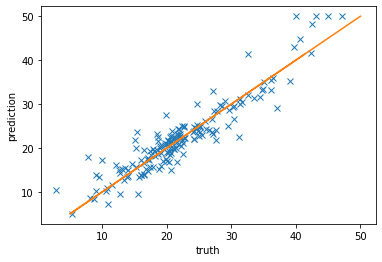

In [57]:
plt.plot(pred.detach().numpy(), test_y.numpy(), "x")
plt.plot(test_y, test_y, "-")
plt.xlabel("truth")
plt.ylabel("prediction")
plt.show()

Now do the same for RBF, what do you expect?